# OpenNEX DCP30 Analysis Using Pandas

This notebook illustrates how to analyze a subset of [OpenNEX DCP30 data](http://opennex.planetos.com/dcp30) using Python and pandas. Specifically, we will be analyzing temperature data in the Chicago area to understand how the CESM1-CAM5 climate model behaves under different RCP scenarios during the course of this century.

A dataset for this example is available at http://opennex.planetos.com/dcp30/k6Lef. On that page you will find a bash script that can be used to deploy a Docker container which will serve the selected data. Deployment of the container is beyond the scope of this example.

<hr>

**Import Required Modules**

Let's begin by importing the required modules. We'll need `pandas` for analysis and `urllib2` to request data from our access server. We'll use `matplotlib` to create a chart of our analysis.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# set default figure size
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8

import pandas as pd
import urllib2

**Loading Data into a Dataframe**

The `load_data` function reads data directly from your access server's endpoint. It accepts the `ip_addr` parameter, which must correspond to the IP address of your data access server.

For local deployments, this may be `localhost` or a local IP address. If you've deployed into an EC2 instance, you'll need to ensure the port is accessible and replace `localhost` with your instance's public IP address.

It's easier to work with the resulting data if we tell pandas about the date and categorical columns. The function declares these column types, and also converts the temperature from degrees Kelvin to degrees Celsius.

In [3]:
def load_data(ip_addr):
    data = pd.read_csv(urllib2.urlopen("http://%s:7645/data.csv" % (ip_addr)))
    for col in ['Model', 'Scenario', 'Variable']:
        data[col] = data[col].astype('category')
    data['Date'] = data['Date'].astype('datetime64')
    data['Temperature'] = data['Value'] - 273.15
    return data

**Plotting the Scenarios**

After loading that data, we can use `matplotlib` to visualize what the model predicts over the course of this century.  This function reduces the data to show the warmest month for each year and displays the values under each RCP scenario.

In [4]:
def do_graph(df):
    model = df.loc[1,'Model']
    df['Year'] = df['Date'].map(lambda d: "%d-01-01" % (d.year)).astype('datetime64')
    by_year = df.groupby(['Year', 'Scenario']).max().loc[:,['Temperature']]
    groups = by_year.reset_index().set_index('Year').groupby('Scenario')
    for key, grp in groups:
        plt.plot(grp.index, grp['Temperature'], label=key)
    plt.legend(loc='best')
    plt.title("Maximum mean temperature for warmest month using model %s" % (model))
    plt.xlabel("Year")
    plt.ylabel("Temperature [Celsius]")
    plt.show()

**Putting it all Together**

Let's load the data, quickly inspect it using the `head` method, then use `do_graph` to visualize it.

In [5]:
# Note: make sure you pass load_data the correct IP address. This is only an example.
data = load_data("localhost")

In [6]:
data.head()

,Date,Longitude,Latitude,Model,Scenario,Variable,Value,Temperature
0,2000-01-01,-87.6458,41.8708,CESM1-CAM5,historical,tasmax,273.052246,-0.097754
1,2000-01-01,-87.6375,41.8708,CESM1-CAM5,historical,tasmax,273.061737,-0.088263
2,2000-01-01,-87.6292,41.8708,CESM1-CAM5,historical,tasmax,273.059784,-0.090216
3,2000-01-01,-87.6208,41.8708,CESM1-CAM5,historical,tasmax,273.168396,0.018396
4,2000-01-01,-87.6125,41.8708,CESM1-CAM5,historical,tasmax,273.170197,0.020197


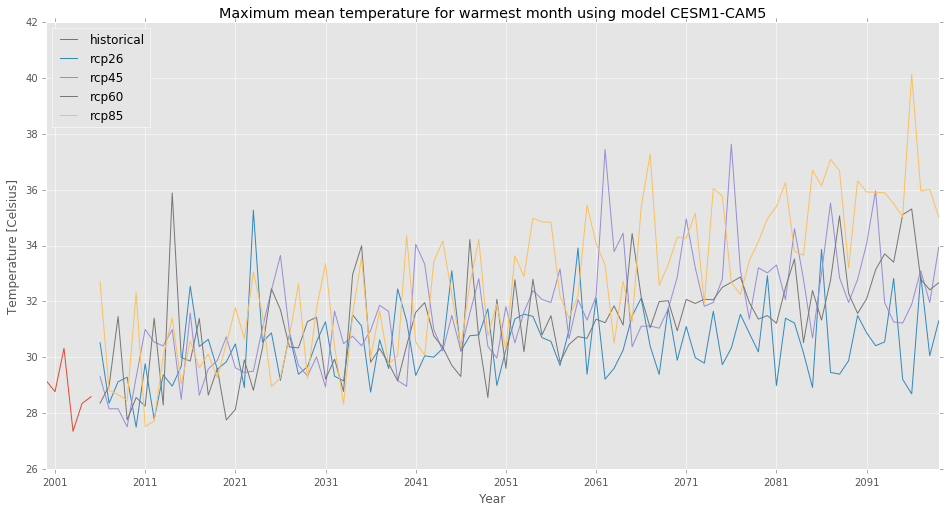

In [7]:
do_graph(data)

**Results**

The plot above begins with a brief historical period at the start of the century, then presents data from the four RCP scenarios. We can see annual fluxuations as well as a clear divergence towards the end of the century. As expected, the most aggressive warming scenario, rcp85, produces the warmest temperatures.